# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design T cells that respond to diseases like cancer.

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import least_squares
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import resample

np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of multivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    assert L0.shape == v.shape
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    ## Solve Req by calling least_squares
    lsq = least_squares(diffFunAnon, np.full_like(L0, Rtot/2.0), jac_sparsity=np.eye(L0.size),
                        max_nfev=1000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        bounds=(np.full_like(L0, -np.finfo(float).eps), np.full_like(L0, Rtot)))
#     if lsq['cost'] > 1.0E-8:
#         print(lsq)
#         raise RuntimeError("Failure in solving for Req.")
        
    Req = lsq.x
    Lbound = np.zeros(Req.size)
    Rmulti = np.zeros(Req.size)
    Rbnd = np.zeros(Req.size)
    
    for ii, Reqq in enumerate(Req):
        # Calculate vieq from equation 1
        vieq = L0[ii]*Reqq*binom(v[ii], np.arange(1, v[ii] + 1))*np.power(Kx*Reqq, np.arange(v[ii]))/Kd

        # Calculate L, according to equation 7
        Lbound[ii] = np.sum(vieq)

        # Calculate Rmulti from equation 5
        Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))

        # Calculate Rbound
        Rbnd[ii] = Rmulti[ii] + vieq[0]

    return (Lbound, Rbnd, Rmulti)

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

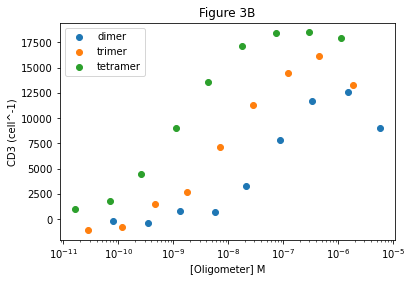

In [5]:
Xs1 = Xs[0:9]
Xs2 = Xs[9:18]
Xs3 = Xs[18:27]

Ys1 = Ys[0:9]
Ys2 = Ys[9:18]
Ys3 = Ys[18:27]

Vs1 = Vs[0:9]
Vs2 = Vs[9:18]
Vs3 = Vs[18:27]

plt.scatter(Xs1,Ys1, label='dimer')
plt.scatter(Xs2,Ys2, label='trimer')
plt.scatter(Xs3,Ys3, label='tetramer')
plt.xscale('log')
plt.legend()
plt.xlabel('[Oligometer] M')
plt.ylabel('CD3 (cell^-1)')
plt.title('Figure 3B')
plt.show()

The relationship I see between Kx, Kd, and valency is that there is none. This is because the valencies in Figure 3B use only one value of Kx and Kd which we can use to infer that Kx and Kd are not affected by the valencies.

#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

/var/folders/1z/f8jdrp1x28qcyj9441xlpz_m0000gr/T/ipykernel_7418/3591770354.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))


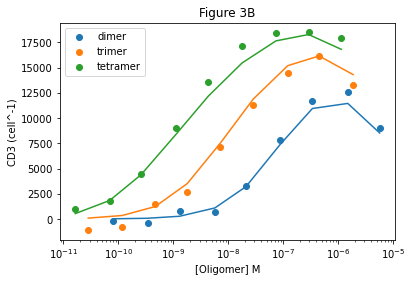

In [6]:
def scalar(Rtot, Kd, v, Kx, L0, scalarValue):
    Rmulti = scalarValue * StoneMod(Rtot, Kd, v, Kx, L0)[2]
    return Rmulti

RmultiScaledVal = scalar(24000, 1.7E-6, Vs, 3.15E-4, Xs, 1)

mod1 = RmultiScaledVal[0:9]
mod2 = RmultiScaledVal[9:18]
mod3 = RmultiScaledVal[18:27]

plt.scatter(Xs1,Ys1, label='dimer')
plt.plot(Xs1, mod1)
plt.scatter(Xs2,Ys2, label='trimer')
plt.plot(Xs2, mod2)
plt.scatter(Xs3,Ys3, label='tetramer')
plt.plot(Xs3, mod3)
plt.xscale('log')
plt.legend()
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.title('Figure 3B')
plt.show()

#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [7]:
def residuals(x0, Xs, Ys, Vs):
    RmultiScaledVal = scalar(24000, x0[1], Vs, x0[2], Xs, x0[0])
    residualArray = Ys - RmultiScaledVal
    return residualArray

x0 = np.array([1, 1.7E-6, 3.15E-4])
leastSquaresSolution = least_squares(residuals, x0, args=(Xs, Ys, Vs))

print("Least squares solution for scalar is: " + str(leastSquaresSolution.x[0]))
print("Least squares solution for Kd is: " + str(leastSquaresSolution.x[1]))
print("Least squares solution for Kx is: " + str(leastSquaresSolution.x[2]))

/var/folders/1z/f8jdrp1x28qcyj9441xlpz_m0000gr/T/ipykernel_7418/3591770354.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))


Least squares solution for scalar is: 1.0281501620230493
Least squares solution for Kd is: 1.7028605650191743e-06
Least squares solution for Kx is: 0.00031473135211874226


#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

/var/folders/1z/f8jdrp1x28qcyj9441xlpz_m0000gr/T/ipykernel_1347/3591770354.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))


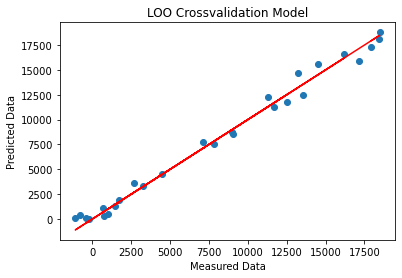

In [230]:
loo = LeaveOneOut()
X = np.zeros(27)

for train_index, test_index in loo.split(Xs):
    X[test_index] = scalar(24000, leastSquaresSolution.x[1], Vs[test_index], leastSquaresSolution.x[2], Xs[test_index], leastSquaresSolution.x[0])

plt.scatter(Ys, X)
plt.plot(Ys, Ys, 'r')
plt.xlabel('Measured Data')
plt.ylabel('Predicted Data')
plt.title('LOO Crossvalidation Model')
plt.show()

Yes, this model predicts the data because the data points are near the line of fit where the equation is y = x.

#### (5) Using bootstrap estimation, plot the confidence interval of the model predictions along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

In [232]:
p_boot = np.empty((3,100))
resamp = np.zeros(27)

for i in range(p_boot.shape[1]):
    resamp = resample(range(Xs.size))
    bootstrapModel = least_squares(residuals, x0, args=(Xs[resamp], Ys[resamp], Vs[resamp]))
    p_boot[:,i] = bootstrapModel.x
    

bootstrapScalar = p_boot[0]
bootstrapKd = p_boot[1]
bootstrapKx = p_boot[2]

Rmulti = np.zeros((100, 27))
for i in range (0,100):
    Rmulti[i] = scalar(24000, bootstrapKd[i], Vs, bootstrapKx[i], Xs, bootstrapScalar[i])
                      
RmultiNew = np.transpose(Rmulti)
RmultiMean = np.zeros(27)
Rmulti25 = np.zeros(27)
Rmulti75 = np.zeros(27)
RmultiLow = np.zeros(27)
RmultiHigh = np.zeros(27)

for i in range (27):
    RmultiMean[i] = np.mean(RmultiNew[i])
    Rmulti25[i] = np.percentile(RmultiNew[i], 25)
    Rmulti75[i] = np.percentile(RmultiNew[i], 75)
    RmultiLow[i] = RmultiMean[i] - Rmulti25[i]
    RmultiHigh[i] = Rmulti75[i] - RmultiMean[i]
                    
RmultiMean1 = RmultiMean[0:9]
RmultiMean2 = RmultiMean[9:18]
RmultiMean3 = RmultiMean[18:27]

                      
RmultiLow1 = RmultiLow[0:9]
RmultiLow2 = RmultiLow[9:18]
RmultiLow3 = RmultiLow[18:27]

RmultiHigh1 = RmultiHigh[0:9]
RmultiHigh2 = RmultiHigh[9:18]
RmultiHigh3 = RmultiHigh[18:27]


/var/folders/1z/f8jdrp1x28qcyj9441xlpz_m0000gr/T/ipykernel_1347/3591770354.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))


Text(0.5, 1.0, 'Bootstrap Estimation with Confidence Intervals')

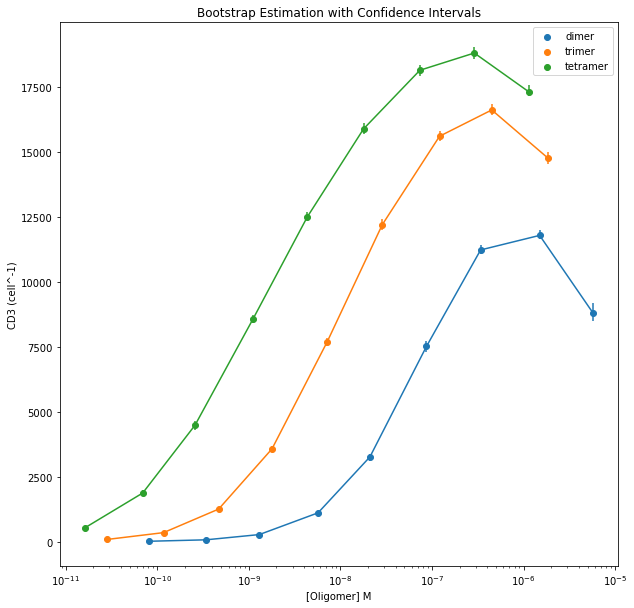

In [233]:
plt.figure(figsize=(10,10))
plt.scatter(Xs1, RmultiMean1, label='dimer')
plt.errorbar(Xs1, RmultiMean1, yerr = [RmultiLow1, RmultiHigh1])
plt.scatter(Xs2, RmultiMean2, label='trimer')
plt.errorbar(Xs2, RmultiMean2, yerr = [RmultiLow2, RmultiHigh2])
plt.scatter(Xs3, RmultiMean3, label='tetramer')
plt.errorbar(Xs3, RmultiMean3, yerr = [RmultiLow3, RmultiHigh3])
plt.xscale('log')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3 (cell^-1)')
plt.legend()
plt.title("Bootstrap Estimation with Confidence Intervals")

#### (6) How would you expect the cross-validation and bootstrap results to change if you had fewer data points?

Explain your answer.

If I had fewer data points, I would expect the cross-validation and bootstrap results to lower the confidence. As a result, the confidence intervals would also increase because of a higher variance between values. The values we could calculate for the mean would be less accurate and deviate further away from the true value. The model's accuracy would decrease.

#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

In [9]:
tenFoldDown = 1/10
tenFoldUp = 10
arr = np.linspace(tenFoldDown,tenFoldUp,100)
Kd = 1.7E-6
Kx = 3.15E-4
Scalar = 1

variedScalar = Scalar * arr
variedKd = Kd * arr
variedKx = Kx * arr

sumSquaredError1 = np.zeros(100)
sumSquaredError2 = np.zeros(100)
sumSquaredError3 = np.zeros(100)

for i in range(100):
    sumSquaredError1[i] = sum(residuals([variedScalar[i], Kd, Kx], Xs, Ys, Vs)*residuals([variedScalar[i], Kd, Kx], Xs, Ys, Vs))
    sumSquaredError2[i] = sum(residuals([Scalar, variedKd[i], Kx], Xs, Ys, Vs)*residuals([Scalar, variedKd[i], Kx], Xs, Ys, Vs))
    sumSquaredError3[i] = sum(residuals([Scalar, Kd, variedKx[i]], Xs, Ys, Vs)*residuals([Scalar, Kd, variedKx[i]], Xs, Ys, Vs))


/var/folders/1z/f8jdrp1x28qcyj9441xlpz_m0000gr/T/ipykernel_7418/3591770354.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))


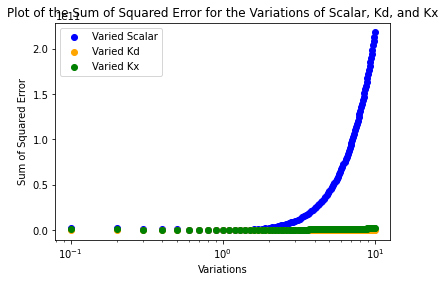

In [249]:
plt.scatter(arr, sumSquaredError1, label='Varied Scalar', c = 'blue')
plt.scatter(arr, sumSquaredError2, label='Varied Kd', c = 'orange')
plt.scatter(arr, sumSquaredError3, label='Varied Kx', c = 'green')
plt.xscale('log')
plt.xlabel('Variations')
plt.ylabel('Sum of Squared Error')
plt.title('Plot of the Sum of Squared Error for the Variations of Scalar, Kd, and Kx')
plt.legend()
plt.show()

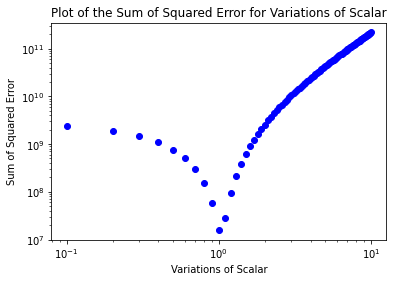

In [250]:
plt.scatter(arr, sumSquaredError1, c = 'blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Variations of Scalar')
plt.ylabel('Sum of Squared Error')
plt.title('Plot of the Sum of Squared Error for Variations of Scalar')
plt.show()

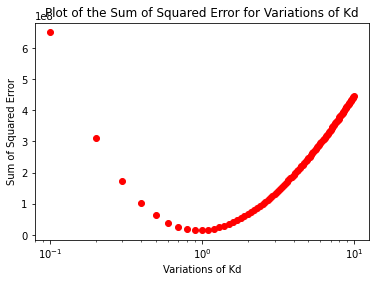

In [251]:
plt.scatter(arr, sumSquaredError2, c = 'red')
plt.xscale('log')
plt.xlabel('Variations of Kd')
plt.ylabel('Sum of Squared Error')
plt.title('Plot of the Sum of Squared Error for Variations of Kd')
plt.show()

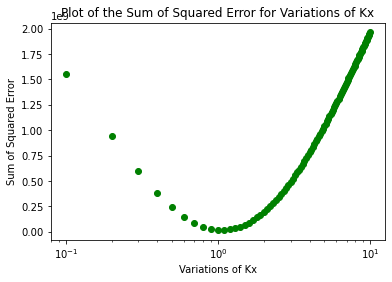

In [252]:
plt.scatter(arr, sumSquaredError3, c = 'green')
plt.xscale('log')
plt.xlabel('Variations of Kx')
plt.ylabel('Sum of Squared Error')
plt.title('Plot of the Sum of Squared Error for Variations of Kx')
plt.show()

The parameter that influences the fit the most is the scalar parameter. The parameter that influences the fit the least is the Kd parameter where at Kd = 0.1, the sum of squared error is about 6.5E8. On the other hand, Kx is higher at 0.1 where the sum of squared error is about 1.55E9.

#### (8) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

I anticipate the predictions of the parameter values to be more specified with a global analysis and be a better model for prediction. This is because if we don't ignore codependency between the parameters, then if a parameter value is changed (e.g. scalar), the other parameters will change as well. As a whole, the model will adjust to such changes and have the least amount of error. 

#### (9) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when $K_d$ increases?

Hint: The easiest way to do this is mess with the bounds of the least squares solver.

In [11]:
sum1 = np.zeros(50)
sum2 = np.zeros(50)
sum3 = np.zeros(50)
arr2 = np.linspace(tenFoldDown,tenFoldUp,50)

for i in range(50):
    varyScalar = leastSquaresSolution.x[0] * arr2[i]
    varyKd = leastSquaresSolution.x[1] * arr2[i]
    varyKx = leastSquaresSolution.x[2] * arr2[i]
    
    optimalScalar = least_squares(residuals, [varyScalar, leastSquaresSolution.x[1], leastSquaresSolution.x[2]], args=(Xs, Ys, Vs), bounds=([0.99*varyScalar, 0, 0], [1.01*varyScalar, np.inf, np.inf]))
    optimalKd = least_squares(residuals, [leastSquaresSolution.x[0], varyKd, leastSquaresSolution.x[2]], args=(Xs, Ys, Vs), bounds=([0,0.99*varyKd,0], [np.inf, 1.01*varyKd, np.inf]))
    optimalKx = least_squares(residuals, [leastSquaresSolution.x[0], leastSquaresSolution.x[1], varyKx], args=(Xs, Ys, Vs), bounds=([0,0,0.99*varyKx], [np.inf, np.inf, 1.01*varyKx]))
    
    sum1[i] = sum(optimalScalar.fun**2)
    sum2[i] = sum(optimalKd.fun**2)
    sum3[i] = sum(optimalKx.fun**2)

    

/var/folders/1z/f8jdrp1x28qcyj9441xlpz_m0000gr/T/ipykernel_7418/3591770354.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))


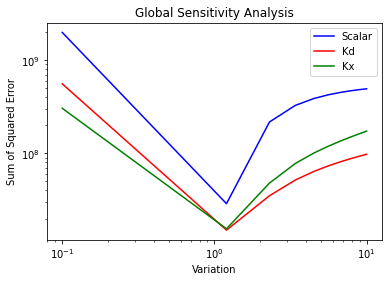

In [256]:
plt.plot(arr2, sum1, 'b')
plt.plot(arr2, sum2, 'r')
plt.plot(arr2, sum3, 'g')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Variation')
plt.ylabel('Sum of Squared Error')
plt.legend(['Scalar','Kd', 'Kx'])
plt.title('Global Sensitivity Analysis')
plt.show()

My prediction was true. As one parameter is changed, the other parameters change as well. When Kd increases, Scalar and Kx increase as well. Thus, there is a global sensitivity to all of the parameters of scalar, Kd, and Kx.

#### (10) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters.

In [257]:
bootstrapXs1 = np.zeros(9)
bootstrapXs2 = np.zeros(9)
bootstrapXs3 = np.zeros(9)

bootstrapYs1 = np.zeros(9)
bootstrapYs2 = np.zeros(9)
bootstrapYs3 = np.zeros(9)

ligandsBound = np.zeros((100,27))
receptorsBound = np.zeros((100,27))

for i in range(100):
    #Had to split the bootstrap into 3 because it takes an hour+ for me to run this cell if it was all stored in one variable
    bootstrapXs1 = np.sort(resample(Xs1))
    bootstrapXs2 = np.sort(resample(Xs2))
    bootstrapXs3 = np.sort(resample(Xs3))
    
    bootstrapYs1 = np.sort(resample(Ys1))
    bootstrapYs2 = np.sort(resample(Ys2))
    bootstrapYs3 = np.sort(resample(Ys3))
    
    bootstrapXs =  np.concatenate([bootstrapXs1, bootstrapXs2, bootstrapXs3])
    bootstrapYs =  np.concatenate([bootstrapYs1, bootstrapYs2, bootstrapYs3])
    
    bootstrapOptimal = least_squares(residuals, x0, args=(bootstrapXs, bootstrapYs, Vs))
    
    ligandsBound[i][:] = StoneMod(24000, bootstrapOptimal.x[1], Vs, bootstrapOptimal.x[2], bootstrapXs)[0]
    receptorsBound[i][:] = StoneMod(24000, bootstrapOptimal.x[1], Vs, bootstrapOptimal.x[2], bootstrapXs)[1]


/var/folders/1z/f8jdrp1x28qcyj9441xlpz_m0000gr/T/ipykernel_1347/3591770354.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))


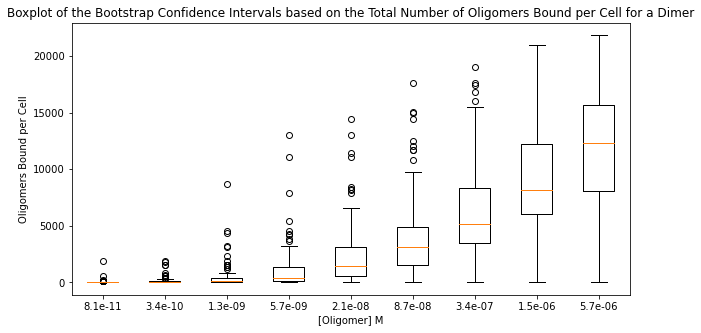

In [258]:
plt.figure(figsize=(10,5))
plt.boxplot(ligandsBound[:,0:9])
plt.xticks(np.linspace(1,9,9), Xs1)
plt.xlabel('[Oligomer] M')
plt.ylabel('Oligomers Bound per Cell')
plt.title('Boxplot of the Bootstrap Confidence Intervals based on the Total Number of Oligomers Bound per Cell for a Dimer')
plt.show()

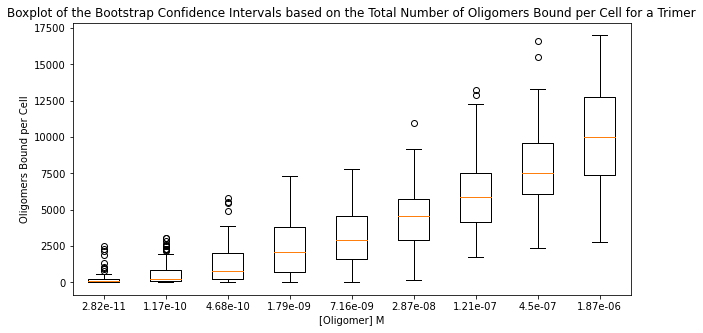

In [259]:
plt.figure(figsize=(10,5))
plt.boxplot(ligandsBound[:,9:18])
plt.xticks(np.linspace(1,9,9), Xs2)
plt.xlabel('[Oligomer] M')
plt.ylabel('Oligomers Bound per Cell')
plt.title('Boxplot of the Bootstrap Confidence Intervals based on the Total Number of Oligomers Bound per Cell for a Trimer')
plt.show()

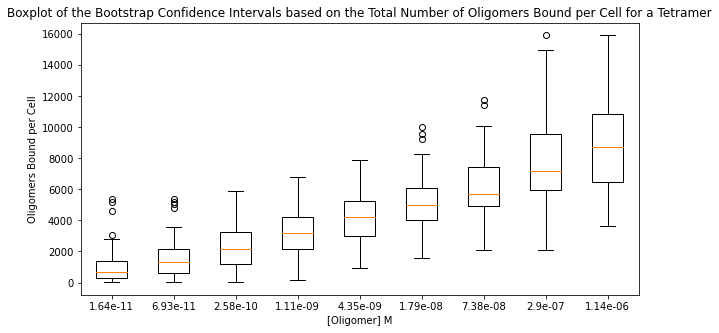

In [260]:
plt.figure(figsize=(10,5))
plt.boxplot(ligandsBound[:,18:27])
plt.xticks(np.linspace(1,9,9), Xs3)
plt.xlabel('[Oligomer] M')
plt.ylabel('Oligomers Bound per Cell')
plt.title('Boxplot of the Bootstrap Confidence Intervals based on the Total Number of Oligomers Bound per Cell for a Tetramer')
plt.show()

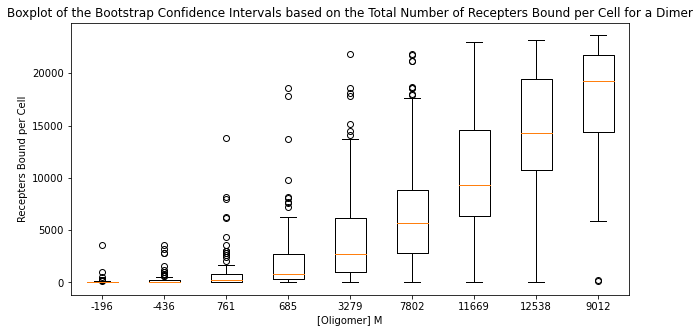

In [261]:
plt.figure(figsize=(10,5))
plt.boxplot(receptorsBound[:,0:9])
plt.xticks(np.linspace(1,9,9), Ys1)
plt.xlabel('[Oligomer] M')
plt.ylabel('Recepters Bound per Cell')
plt.title('Boxplot of the Bootstrap Confidence Intervals based on the Total Number of Recepters Bound per Cell for a Dimer')
plt.show()

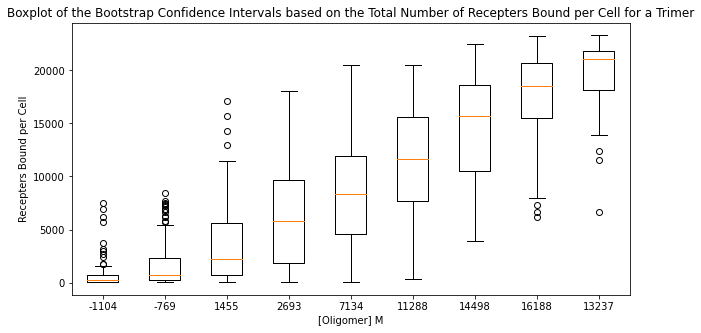

In [262]:
plt.figure(figsize=(10,5))
plt.boxplot(receptorsBound[:,9:18])
plt.xticks(np.linspace(1,9,9), Ys2)
plt.xlabel('[Oligomer] M')
plt.ylabel('Recepters Bound per Cell')
plt.title('Boxplot of the Bootstrap Confidence Intervals based on the Total Number of Recepters Bound per Cell for a Trimer')
plt.show()

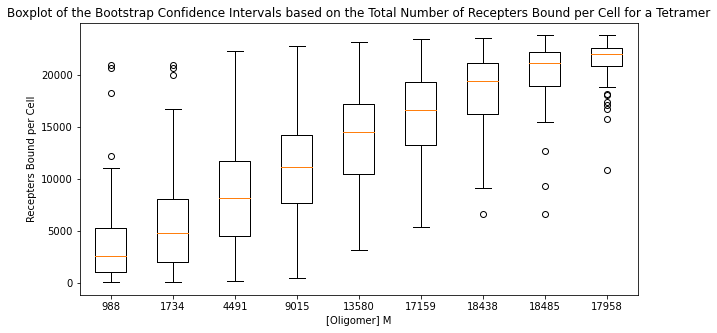

In [263]:
plt.figure(figsize=(10,5))
plt.boxplot(receptorsBound[:,18:27])
plt.xticks(np.linspace(1,9,9), Ys3)
plt.xlabel('[Oligomer] M')
plt.ylabel('Recepters Bound per Cell')
plt.title('Boxplot of the Bootstrap Confidence Intervals based on the Total Number of Recepters Bound per Cell for a Tetramer')
plt.show()